# What Makes A Good Speech?

From csv ted_talks_en.csv

URL:  https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset/data

Columns = 'talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations', 'about_speakers', 'views', 'recorded_date', 'published_date', 'event', 'native_lang', 'available_lang', 'comments', 'duration', 'topics', 'related_talks', 'url', 'description', 'transcript'.

Still Needed:
- Intro
- Data sets used
- Data Dictionary


Intro:
# we have two csv files, one with the transcripts and one with the likes data.
# we will import them both here and merge them into one dataframe
transcript_df = pd.read_csv("TED Dataset #1 (n-4003) with Transcripts.csv")
likes_df = pd.read_csv("TED Dataset #2 (n=5701).csv")


# Next Steps:
(as of January 23rd, 2023)

- Clean up the notebook for maximum transparency of workflow
- Reassess next steps based on feedback and re-assessment of options given the scope of the project.

# Data Dictionary



# Table of Contents:

1. Merging the DataFrames
2. Data Cleaning
3. Initial EDA
4. Feature Engineering (Vectorizing Text)
5. Model Building & Determining the Features of Highest Influence

In [51]:
# importing necessary libraries
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text 
from nltk.tokenize import word_tokenize
import string
import ast

## 1. Merging the DataFrames

In [52]:
# we have two csv files, one with the transcripts and one with the likes data.
# we will import them both here and merge them into one dataframe
transcript_df = pd.read_csv("TED Dataset #1 (n-4003) with Transcripts.csv")
likes_df = pd.read_csv("TED Dataset #2 (n=5701).csv")

In [53]:
# options to display all columns and rows
pd.options.display.max_rows = 5
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 30

In [54]:
# viewing the first 3 rows of the transcript dataframe
transcript_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gor...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', '...",272.0,977,"['alternative energy', 'ca...",{243: 'New thinking on the...,https://www.ted.com/talks/...,With the same humor and hu...,"Thank you so much, Chris. ..."
1,92,The best stats you've ever...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert...,{0: 'In Hans Rosling’s han...,14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', '...",628.0,1190,"['Africa', 'Asia', 'Google...","{2056: ""Own your body's da...",https://www.ted.com/talks/...,You've never seen data pre...,"About 10 years ago, I took..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the pe...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', '...",124.0,1286,"['computers', 'entertainme...",{1725: '10 top time-saving...,https://www.ted.com/talks/...,New York Times columnist D...,"(Music: ""The Sound of Sile..."


In [55]:
# viewing the first 3 rows of the likes dataframe
likes_df.head(3)

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


In [56]:
print(transcript_df.shape)
print(likes_df.shape)

(4005, 19)
(5701, 9)


There are 4005 rows in the transcipts dataframe.  As this dataframe has the transcript data we wish to use, we will be limited to at least that number of samples after the merge.

We will merge the dataframes to obtain [from the larger 'likes' dataframe] the likes and (updated) views columns. 

Lets investigate how many times each dataframe contains the same primary key to merge on - this will tell us how many rows of data we will actually have to work with after the merge.  

#### Investigating how our data will look after merging:

Calculating the matches of talk_id (our primary key).

In [57]:
# the dataframe with the transcripts has 4003 rows and 3 columns.  How many rows will we have in our merged dataframe?
# to do this, lets check to make sure that the talk_id's are unique in the likes dataframe, 
# and check how many talk_id's in our smaller "likes_df" match those in our larger "transcript_df".  This whill show us, assuming all other information is there, how many rows we will have in our merged dataframe.

# extracting the unique talk_id's from both dataframes
unique_likes = set(likes_df['talk_id'].unique())
unique_transcripts = set(transcript_df['talk_id'].unique())
matching_talk_ids = unique_likes & unique_transcripts

# checking to see if the talk_id's are unique in the likes dataframe
if unique_likes == unique_transcripts:
    print("The talk_id's are unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")
else:
    print("The talk_id's are not unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")

    # finding out which 'talk_id's are different between the two dataframes
    missing_in_likes = unique_transcripts - unique_likes
    missing_in_transcripts = unique_likes - unique_transcripts

    print("There are a total of: ", len(missing_in_likes), "Missing in likes_df:", missing_in_likes)
    print("There are a total of: ", len(missing_in_transcripts), "Missing in transcripts_df:", missing_in_transcripts)

The talk_id's are not unique in both dataframes
There are a total of: 3996 matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.
There are a total of:  9 Missing in likes_df: {323, 45412, 2405, 2127, 3632, 2577, 2453, 2102, 347}
There are a total of:  1705 Missing in transcripts_df: {40965, 98324, 24, 8225, 57377, 57378, 81960, 81961, 81962, 81963, 90154, 90162, 81988, 98381, 98383, 81999, 82000, 82001, 82002, 82003, 82004, 65622, 82005, 82006, 73824, 73825, 82027, 57461, 41093, 82056, 82057, 138, 82058, 169, 90282, 49324, 82092, 82094, 82095, 82093, 90287, 90288, 73908, 186, 90330, 73953, 73954, 8424, 8425, 8426, 8427, 8428, 8429, 49391, 49392, 49394, 49395, 49399, 98559, 82179, 265, 74002, 74003, 74006, 98590, 98591, 65825, 290, 90404, 90405, 49450, 82218, 24874, 24876, 65856, 74051, 65876, 65877, 65878, 65879, 90453, 65881, 98662, 82289, 41330, 82290, 65915, 82299, 82300, 82301, 82302, 16778, 16779, 8590, 82318, 8592, 98706, 9

Since there are 3996 matching talk ID's this is how many talks we have to analyze (prior to data cleaning and pre-processing).

#### Merging the dataframes:

In [58]:
# I will add a suffix of "_new" to this more updated dataset, so that I know which columns are from which dataset after merging them.
# Select the columns you want to rename
columns_to_modify = ['duration', 'event', 'recorded_date', 'views', 'title', 'published_date']

# Create a dictionary where the keys are the old column names and the values are the new column names
renamed_columns = {col: col + '_from_likes_df' for col in columns_to_modify}

# Rename the columns in the DataFrame
likes_df.rename(columns=renamed_columns, inplace=True)
likes_df.head(3)

,talk_id,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


### Ready to merge the dataframes

In [59]:
# I will now merge the two dataframes together, using the talk_id as the key.
merged_df = transcript_df.merge(likes_df, on='talk_id')
merged_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gor...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', '...",272.0,977,"['alternative energy', 'ca...",{243: 'New thinking on the...,https://www.ted.com/talks/...,With the same humor and hu...,"Thank you so much, Chris. ...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,92,The best stats you've ever...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert...,{0: 'In Hans Rosling’s han...,14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', '...",628.0,1190,"['Africa', 'Asia', 'Google...","{2056: ""Own your body's da...",https://www.ted.com/talks/...,You've never seen data pre...,"About 10 years ago, I took...",The best stats you've ever...,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the pe...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', '...",124.0,1286,"['computers', 'entertainme...",{1725: '10 top time-saving...,https://www.ted.com/talks/...,New York Times columnist D...,"(Music: ""The Sound of Sile...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000


#### Removing duplicate columns

In [60]:
# Lets see which columns are redundant, and which ones we can drop.
merged_df.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript',
       'title_from_likes_df', 'speaker', 'recorded_date_from_likes_df',
       'published_date_from_likes_df', 'event_from_likes_df',
       'duration_from_likes_df', 'views_from_likes_df', 'likes'],
      dtype='object')

In [61]:
# here we'll remove duplicate columns
merged_cleaved_df = merged_df.drop(["speaker_1", "title_from_likes_df", "views", "recorded_date_from_likes_df", "published_date_from_likes_df", "event_from_likes_df", "duration_from_likes_df"], axis=1)
merged_cleaved_df

,talk_id,title,all_speakers,occupations,about_speakers,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,speaker,views_from_likes_df,likes
0,1,Averting the climate crisis,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gor...,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', '...",272.0,977,"['alternative energy', 'ca...",{243: 'New thinking on the...,https://www.ted.com/talks/...,With the same humor and hu...,"Thank you so much, Chris. ...",Al Gore,3681537,110000
1,92,The best stats you've ever...,{0: 'Hans Rosling'},{0: ['global health expert...,{0: 'In Hans Rosling’s han...,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', '...",628.0,1190,"['Africa', 'Asia', 'Google...","{2056: ""Own your body's da...",https://www.ted.com/talks/...,You've never seen data pre...,"About 10 years ago, I took...",Hans Rosling,15432904,462000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,62784,The electrifying speeches ...,{0: 'Daina Ramey Berry'},NaN,NaN,2020-04-28,2020-04-30,TED-Ed,en,['en'],NaN,257,"['TED-Ed', 'education', 'a...",{20973: 'The breathtaking ...,https://www.ted.com/talks/...,Isabella Baumfree was born...,"In early 1828, Sojourner T...",Daina Ramey Berry,402898,12000
3995,62794,The most important anus in...,{0: 'Cella Wright'},NaN,NaN,2020-04-30,2020-04-30,TED-Ed,en,['en'],NaN,281,"['animals', 'TED-Ed', 'ani...",{62347: 'The bug that poop...,https://www.ted.com/talks/...,Is it a fuzzy sock? An ove...,Can you guess what you’re ...,Cella Wright,436255,13000


#### Clean column names

In [62]:
# Here we're removing the '_y' from any column names that have it
# merged_cleaved_df.columns = [col.rstrip('_y') if col.endswith('_y') else col for col in merged_cleaved_df.columns]
merged_cleaved_df.columns = [col.rstrip('_from_likes_df') if col.endswith('_from_likes_df') else col for col in merged_cleaved_df.columns]
merged_cleaved_df

,talk_id,title,all_speakers,occupations,about_speakers,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,speaker,view,likes
0,1,Averting the climate crisis,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gor...,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', '...",272.0,977,"['alternative energy', 'ca...",{243: 'New thinking on the...,https://www.ted.com/talks/...,With the same humor and hu...,"Thank you so much, Chris. ...",Al Gore,3681537,110000
1,92,The best stats you've ever...,{0: 'Hans Rosling'},{0: ['global health expert...,{0: 'In Hans Rosling’s han...,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', '...",628.0,1190,"['Africa', 'Asia', 'Google...","{2056: ""Own your body's da...",https://www.ted.com/talks/...,You've never seen data pre...,"About 10 years ago, I took...",Hans Rosling,15432904,462000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,62784,The electrifying speeches ...,{0: 'Daina Ramey Berry'},NaN,NaN,2020-04-28,2020-04-30,TED-Ed,en,['en'],NaN,257,"['TED-Ed', 'education', 'a...",{20973: 'The breathtaking ...,https://www.ted.com/talks/...,Isabella Baumfree was born...,"In early 1828, Sojourner T...",Daina Ramey Berry,402898,12000
3995,62794,The most important anus in...,{0: 'Cella Wright'},NaN,NaN,2020-04-30,2020-04-30,TED-Ed,en,['en'],NaN,281,"['animals', 'TED-Ed', 'ani...",{62347: 'The bug that poop...,https://www.ted.com/talks/...,Is it a fuzzy sock? An ove...,Can you guess what you’re ...,Cella Wright,436255,13000


In [63]:
# There are no more duplicate columns
print(merged_cleaved_df.columns)
print(merged_cleaved_df.shape)

Index(['talk_id', 'title', 'all_speakers', 'occupations', 'about_speakers',
       'recorded_date', 'published_date', 'event', 'native_lang',
       'available_lang', 'comments', 'duration', 'topics', 'related_talks',
       'url', 'description', 'transcript', 'speaker', 'view', 'likes'],
      dtype='object')
(3996, 20)


There are no more duplicate columns.  

The dataset has 3996 rows and 20 columns in the merged_df dataframe.

## 2. Data Cleaning

- dealing with nulls
- addressing datatypes


### WHAT TO DO WITH THESE HEADINGS?  Where we'll go from here:

- Exclude the transcript from a dataframe for initial EDA

### Dealing with nulls

In [64]:
# how many nulls do we have now?
pd.options.display.max_rows = 25
merged_cleaved_df.isnull().sum()

talk_id             0
title               0
all_speakers        4
occupations       522
about_speakers    503
recorded_date       1
published_date      0
event               0
native_lang         0
available_lang      0
comments          654
duration            0
topics              0
related_talks       0
url                 0
description         0
transcript          0
speaker             0
view                0
likes               0
dtype: int64

For the moment, while removing nulls will result in ((3996-3331) / 3996 = 0.1664) 16.4% of the data being thrown out, scraping additional data from the TED website is beyond the scope of this project, so we will continue without this data. 

In [65]:
# Lets see what happens to the 3996 rows when we drop the null values
merged_cleaved_df.dropna(inplace=True)

In [66]:
merged_cleaved_df.shape

(3330, 20)

### Addressing Datatypes

We're going to, one by one, determine what to do with each of the "object" columns. 
Options include:
- Change into numerical values
- Clean for CountVectorization
- Clean for Dummy / Multi-Label-Binarizing
- Drop

#### Columns to address, and what was done to them:

- all_speakers      3331 non-null   object **DROPPED / multiple_speakers variable created**
- occupations       3331 non-null   object **ready for dummy variables - May Drop**
- about_speakers    3331 non-null   object **DROPPING**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object  **DROPPED**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create  (via MultiLabel Binarizer)**
- related_talks     3331 non-null   object **Possible Future CountVectorization**
- url               3331 non-null   object **DROPPED**
- description       3331 non-null   object **Possible Future CountVectorization**
- transcript        3331 non-null   object **CountVectorize**
- title             3331 non-null   object **Possible Future CountVectorization**
- speaker           3331 non-null   object **DROPPED**
- recorded_date     3331 non-null   object **Changed to DateTime**
- published_date    3331 non-null   object **Changed to DateTime**
- event             3331 non-null   object **ted_mainstage variable created**

 #### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

We'll start with "all_speakers" (for this section of the notebook, the column we are addressing in the section below will be made a headline, as is "all_speakers" below)

#### - all_speakers      3331 non-null   object **DROPPED / multiple_speakers variable created**

In [67]:
merged_cleaved_df["all_speakers"].value_counts()

all_speakers
{0: 'Hans Rosling'}            9
{0: 'Greg Gage'}               9
{0: 'Juan Enriquez'}           9
{0: 'Marco Tempest'}           7
{0: ' Rives'}                  6
                              ..
{0: 'Ryan Merkley'}            1
{0: 'Pankaj Ghemawat'}         1
{0: 'David Pizarro'}           1
{0: 'Lemn Sissay'}             1
{0: 'Dick M. Carpenter II'}    1
Name: count, Length: 2851, dtype: int64

In [68]:
# Let's find out how many talks have multiple speakers
# Assuming all_speakers is a list of dictionaries
all_speakers = merged_cleaved_df["all_speakers"]

# Initialize a counter
count = 0

# Iterate through each dictionary in the list
for speaker_dict in all_speakers:
    # Check if the key "1" exists in the dictionary
    if "1" in speaker_dict:
        count += 1

# Output the result
print(f"Number of dictionaries with a key '1': {count}")

Number of dictionaries with a key '1': 103


There are 103 talks with multiple speakers in them.  
As much of the data in 'all_speakers' is redundant as it repeats the value of the main speaker, we will drop this column.

We will, however, create a dummy column "multiple_speakers" to see if the presence of multiple speakers impacts the outcome of the speech.  

In [69]:
# Assuming merged_cleaved_df is your existing DataFrame
all_speakers = merged_cleaved_df["all_speakers"]

# Using list comprehension to create a one-hot encoded column
merged_cleaved_df['multiple_speakers'] = [1 if "1" in speaker_dict else 0 for speaker_dict in all_speakers]

# Now, merged_cleaved_df has a new column 'multiple_speakers' with one hot encoding


In [70]:
# Dropping the "all_speakers" column, as it is not useful for our analysis
merged_cleaved_df.drop(["all_speakers"], axis=1, inplace=True)

#### - occupations       3331 non-null   object **ready for dummy variables - May Drop**

In [71]:
merged_cleaved_df["occupations"].value_counts()

occupations
{0: ['writer']}                                   52
{0: ['journalist']}                               43
{0: ['entrepreneur']}                             42
{0: ['artist']}                                   40
{0: ['designer']}                                 37
                                                  ..
{0: ['bow designer']}                              1
{0: ['explorer and filmmaker']}                    1
{0: ['human-computer interaction researcher']}     1
{0: ['composer', 'inventor'], 1: ['musician']}     1
{0: ['law researcher']}                            1
Name: count, Length: 1982, dtype: int64

Let's clean these by removing them from their current dictionary format.

In [72]:
# Here we're going to split the "occupations" column into a list of occupations

def transform_occupation(occupation_str):
    # Extracting the part after "{0: " and before the first occurrence of "],"
    match = re.search(r"\{0: \[([^\]]*)\]", occupation_str)
    if match:
        occupations = match.group(1)
        # Remove quotes and split by comma to get individual occupations
        occupations = occupations.replace("'", "").split(", ")
        # Replace spaces within occupations with underscores
        occupations = [occupation.replace(" ", "_") for occupation in occupations]
        # Join the occupations back with a space
        return " ".join(occupations)
    else:
        # Return an empty string or some default value if the pattern is not found
        return ""

# Apply the function to the 'occupations' column
merged_cleaved_df['transformed_occupations'] = merged_cleaved_df['occupations'].apply(transform_occupation)
merged_cleaved_df['transformed_occupations'].value_counts()


transformed_occupations
writer                             54
journalist                         44
entrepreneur                       43
artist                             41
designer                           37
                                   ..
former_prime_minister_of_greece     1
graphic_artist director             1
dolphin_researcher                  1
undercover_journalist               1
law_researcher                      1
Name: count, Length: 1924, dtype: int64

### Transforming Occupations Into Dummies?

The following code is hashed-out as we are trying to limit variables in our modelling (as there are only 3330 rows in the dataset, creating too many variables will risk creating more columns then there are variables).  We can consider including it at a later time.

In [73]:
# # Load your actual DataFrame here
# # merged_cleaved_df = pd.read_csv('your_file.csv')

# # Convert 'transformed_occupations' into dummy variables
# occupation_dummies = pd.get_dummies(merged_cleaved_df['transformed_occupations'], drop_first=True)

# # Define X and y
# X = occupation_dummies
# y = merged_cleaved_df['percent_likes']

# # Splitting the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Adding a constant to the model for the training data
# X_train = sm.add_constant(X_train)

# # Linear Regression on Training Data
# model = sm.OLS(y_train, X_train)
# result = model.fit()

# # Optionally: Evaluate model performance on test data
# X_test = sm.add_constant(X_test)
# predictions = result.predict(X_test)


# # Getting the coefficients from the trained model
# coefficients = result.params

# # Dropping the constant for the purpose of this analysis
# coefficients = coefficients.drop('const', errors='ignore')

# # Sorting the coefficients
# sorted_coefficients = coefficients.sort_values()

# # Selecting the top 10 positive and negative coefficients
# top_10_positive = sorted_coefficients.tail(10)
# top_10_negative = sorted_coefficients.head(10)

# # Plotting
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# # Plot for top 10 positive coefficients
# top_10_positive.plot(kind='barh', ax=axes[0], color='green')
# axes[0].set_title('Top 10 Positive Coefficients')
# axes[0].set_xlabel('Coefficient Value')
# axes[0].set_ylabel('Occupations')

# # Plot for top


In [74]:
# again, the above code is hashed out as it creates too many columns. 
occupation_dummies

NameError: name 'occupation_dummies' is not defined

#### - about_speakers  3331 non-null   object **DROPPING**

In [75]:
merged_cleaved_df['about_speakers']

0       {0: 'Nobel Laureate Al Gor...
1       {0: 'In Hans Rosling’s han...
2       {0: 'David Pogue is the pe...
3       {0: 'Majora Carter redefin...
4       {0: "Creativity expert Sir...
                    ...              
3985    {0: 'A political strategis...
3986    {0: 'With a style that cra...
3990    {0: "TED Prize winner Larr...
3991    {0: 'Nancy Lublin, cofound...
3993    {0: 'Dick M. Carpenter II ...
Name: about_speakers, Length: 3330, dtype: object

For the scope of this analyses, we will drop this column.  

In [76]:
# Dropping the "all_speakers" column, as it is not useful for our analysis
merged_cleaved_df.drop(["about_speakers"], axis=1, inplace=True)

#### - native_lang       3331 non-null   object DROPPING

In [77]:
merged_cleaved_df["native_lang"].value_counts()

native_lang
en       3298
es         15
fr          7
hi          2
de          1
pt          1
ko          1
zh-cn       1
ar          1
pt-br       1
ja          1
it          1
Name: count, dtype: int64

As the vast majority of this column represents English ("en") as being the native language, we will drop this column.

In [78]:
merged_cleaved_df = merged_cleaved_df.drop("native_lang", axis=1)

#### - available_lang    3331 non-null   object DROPPING

In [79]:
merged_cleaved_df["available_lang"].value_counts()

available_lang
['en']                                                                                                                                                                                                    14
['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                          6
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                                4
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sr', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                    4
['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'he', 'hr', 'hu', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sk', 'sr', 'sv', 'th', 'tr',

As we are attempting to limit features, I will drop this column.

In [80]:
merged_cleaved_df = merged_cleaved_df.drop("available_lang", axis=1)

#### - comments          3331 non-null   float64   **leave as-is**

The comments are ready for processing as they are already numerically represented. 

#### - topics            3331 non-null   object **Turn into dummy variables via Multi Label Binarizing**

In [81]:
merged_cleaved_df["topics"].value_counts()

topics
['art', 'creativity']                                                                                                                                                                                                        2
['TED Fellows', 'photography', 'war']                                                                                                                                                                                        2
['charter for compassion', 'compassion', 'global issues', 'religion']                                                                                                                                                        2
['design', 'entertainment', 'live music', 'music', 'technology']                                                                                                                                                             2
['architecture', 'cities', 'design', 'infrastructure']                                               

We will turn these into dummy variables via a MultiLabelBinarizer in the next section. 

#### - related_talks     3331 non-null   object  DROPPING

In [82]:
merged_cleaved_df["related_talks"].value_counts()

related_talks
{243: 'New thinking on the climate crisis', 547: 'The business logic of sustainability', 2093: 'The state of the climate — and what we might do about it', 54715: 'How we can turn the tide on climate', 29968: 'The most important thing you can do to fight climate change: talk about it', 2339: "Climate change is happening. Here's how we adapt"}                  1
{2387: 'The untapped genius that could change science for the better', 2504: 'Good news in the fight against pancreatic cancer', 2821: 'A simple new blood test that can catch cancer early', 53671: 'How does chemotherapy work?', 2467: 'A new superweapon in the fight against cancer', 20919: 'How cancer cells communicate -- and how we can slow them down'}       1
{40727: 'How to revive your belief in democracy', 2104: 'How to upgrade democracy for the Internet era', 2060: 'Why ordinary people need to understand power', 29521: "What's needed to bring the US voting system into the 21st century", 51845: 'Why do Americans 

For the scope of this project, we will drop this column.

In [83]:
merged_cleaved_df = merged_cleaved_df.drop("related_talks", axis=1)

#### - url               3331 non-null   object **DROPPED**

We will drop the URL column.

In [84]:
# dropping the URL column
merged_cleaved_df.drop(["url"], axis=1, inplace=True)

#### - description       3331 non-null   object DROPPED

In [85]:
merged_cleaved_df["description"].value_counts()

description
With the same humor and humanity he exuded in "An Inconvenient Truth," Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.                                                                                                                                                                                                                                                                               1
After decades of research and billions spent in clinical trials, we still have a problem with cancer drug delivery, says biomedical engineer Elizabeth Wayne. Chemotherapy kills cancer -- but it kills the rest of your body, too. Instead of using human design to fight cancer, why not use nature's? In this quick talk, Wayne explains how her lab is creating nanoparticle treatments that bind to immune cells, your body's first responders, to precisely target cancer cells without dama

As this column has little to do with the giving of the speech itself, we will drop this column.

In [86]:
# dropping the description column
merged_cleaved_df.drop(["description"], axis=1, inplace=True)

#### - transcript        3331 non-null   object 

In [87]:
merged_cleaved_df["transcript"].value_counts()

transcript
Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. (Laughter) Put yourselves in my position. (Laughter) I flew on Air Force Two for eight years. (Laughter) Now I have to take off my shoes or boots to get on an airplane! (Laughter) (Applause) I'll tell you one quick story to illustrate what that's been like for me. (Laughter) It's a true story — every bit of this is true. Soon after Tipper and I left the — (Mock sob) White House — (Laughter) we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves. (Laughter) I know it sounds like a little thing to you, but — (Laughter) I looked in the rear-view mirror and all of a sudden it just hit me.

This column is ready to be CountVectorized.  We will address CountVectorization in the next section. 

#### - title             3331 non-null   object (Possible Count Vectorization)

In [88]:
merged_cleaved_df["title"].value_counts()

title
Averting the climate crisis                             1
We can hack our immune cells to fight cancer            1
There's no such thing as not voting                     1
Why you should know how much your coworkers get paid    1
Why open a school? To close a prison                    1
                                                       ..
A TED speaker's worst nightmare                         1
Design to challenge reality                             1
Why you will fail to have a great career                1
The cockroach beatbox                                   1
How "policing for profit" undermines your rights        1
Name: count, Length: 3330, dtype: int64

I am considering CountVectorizing this column.  For now we will leave as-is.  CountVectorizing MAY be done in the next section.  

#### - speaker           3331 non-null   object

In [89]:
merged_cleaved_df["speaker"].value_counts()

speaker
Greg Gage                  9
Juan Enriquez              9
Hans Rosling               9
Marco Tempest              7
Bill Gates                 6
                          ..
Sue Austin                 1
Boghuma Kabisen Titanji    1
Andy Puddicombe            1
Angela Patton              1
Dick M. Carpenter II       1
Name: count, Length: 2843, dtype: int64

As this column has little to do with the speech itself, and because we are trying to limit the number of features to the number of rows, I will drop this column.  

It is noteworthy that WHO a speaker is would likely impact their rating on the speech itself, as each person represents their own personal brand, and when someone "likes" a speech they are in part "liking" that person's personal brand.  But given that the number of features we have is limited to the number of rows that we have, dummying the speaker names would create too many features to justify it's influence on our question "what makes a great speech"?

In [90]:
# dropping the speaker column
merged_cleaved_df.drop(["speaker"], axis=1, inplace=True)

#### - recorded_date     3331 non-null   object 
#### - published_date    3331 non-null   object 

I will change these dates into DateTime datatypes.

In [91]:
merged_cleaved_df["published_date"] = pd.to_datetime(merged_cleaved_df["published_date"])
merged_cleaved_df["recorded_date"] = pd.to_datetime(merged_cleaved_df["recorded_date"])

#### event             3331 non-null   object 

In [92]:
merged_cleaved_df["event"].value_counts()

event
TED2017                    96
TED2018                    95
TED2019                    91
TED2014                    83
TED2009                    81
                           ..
TEDSalon NY2015             1
TEDxIndianapolis            1
TEDxChapmanU                1
TEDxGoldenGatePark 2012     1
TEDxCreativeCoast           1
Name: count, Length: 428, dtype: int64

I will create a binary "ted_mainstage" column in the next section, to differentiate between TED and TEDx (and other) events.

## Feature Engineering

#### We will create the following features:
- percent_likes (likes / views)
- ted_mainstage (mainstage ted events)
- word_count (from the "transcript" column)
- words_per_minute (total_words_count / duration)
- total_question_count (summing the instances of "?" in the transcript)
- questions_per_minute (total_question_count / duration)
- total_laugh_count ("Laughter" is included in the transcripts, and we will sum these occurrences)
- laugh_per_minute (total_laugh_count / duration)
- multiple_speakers (dummy variable - wether there were multiple speakers or not - created in the previous section)
- published month
- published year
- recorded month
- recorded year


#### We will Dummying (via MultiLabelBinarizing) the following columns:
- Occupation
- Topic

#### We will CountVectorize the following columns:
- Transcript
- Title
- Description



#### Percent likes feature
- Create a "percent_likes" feature

In [93]:
# here we'll create a "percent_likes" column, which is the percentage of likes out of the total views
merged_cleaved_df['percent_likes'] = merged_cleaved_df['likes'] / merged_cleaved_df['view']

#### Ted Mainstage Feature

- Create a binanry "main_stage" feature (from "event", which ones are mainstage TED talks vs which ones are 'Tedx'-like talks)

In [94]:
# Here we'll create a 'ted_mainstage' column, which is a boolean column that is True if the talk was performed at a mainstream "TED" event, and False if it was not.
# This is a regex pattern that matches the TED events that are not TEDx or TED Global
mainstage = '^\s*TED\d{4}\s*$'

# Create a binary column based on the condition
merged_cleaved_df['ted_mainstage'] = merged_cleaved_df['event'].str.match(mainstage).astype(int)
merged_cleaved_df['ted_mainstage'].value_counts()


ted_mainstage
0    2154
1    1176
Name: count, dtype: int64

#### Word count columns

In [95]:
# Lets create another column that counts the number of words in the transcript.
# A function that counts words in a string
def count_words(text):
    # Splitting the text into words and count them
    return len(text.split())

# Apply this function to each row in the 'transcript' column and create a new column
merged_cleaved_df['word_count'] = merged_cleaved_df['transcript'].apply(count_words)


#### Words per minute

In [96]:
# words count per minute
merged_cleaved_df['words_per_minute'] = merged_cleaved_df['word_count'] / merged_cleaved_df['duration']

#### Total Question Count and Questions per Minute

In [97]:
# Define a function that counts question marks in a given string
def count_question_marks(text):
    return text.count('?')

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_question_marks'] = merged_cleaved_df['transcript'].apply(count_question_marks)
merged_cleaved_df['questions_per_minute'] = merged_cleaved_df['num_question_marks'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,title,occupations,recorded_date,published_date,event,comments,duration,topics,transcript,view,likes,multiple_speakers,transformed_occupations,percent_likes,ted_mainstage,word_count,words_per_minute,num_question_marks,questions_per_minute
0,1,Averting the climate crisis,{0: ['climate advocate']},2006-02-25,2006-06-27,TED2006,272.0,977,"['alternative energy', 'ca...","Thank you so much, Chris. ...",3681537,110000,0,climate_advocate,0.029879,1,2153,2.203685,8,0.008188
1,92,The best stats you've ever...,{0: ['global health expert...,2006-02-22,2006-06-27,TED2006,628.0,1190,"['Africa', 'Asia', 'Google...","About 10 years ago, I took...",15432904,462000,0,global_health_expert;_data...,0.029936,1,3174,2.667227,22,0.018487
2,7,Simplicity sells,{0: ['technology columnist']},2006-02-24,2006-06-27,TED2006,124.0,1286,"['computers', 'entertainme...","(Music: ""The Sound of Sile...",2012797,60000,0,technology_columnist,0.029809,1,3371,2.621306,35,0.027216


#### Total Laugh Count and Laughs per Minute

In [98]:
# Create a function that counts the number of "(Laughter)" in a string.
def count_laughter(text):
    # Splitting the text into words and count them
    return text.count("(Laughter)")

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_laughs'] = merged_cleaved_df['transcript'].apply(count_laughter)
merged_cleaved_df['laughs_per_minute'] = merged_cleaved_df['num_laughs'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,title,occupations,recorded_date,published_date,event,comments,duration,topics,transcript,view,likes,multiple_speakers,transformed_occupations,percent_likes,ted_mainstage,word_count,words_per_minute,num_question_marks,questions_per_minute,num_laughs,laughs_per_minute
0,1,Averting the climate crisis,{0: ['climate advocate']},2006-02-25,2006-06-27,TED2006,272.0,977,"['alternative energy', 'ca...","Thank you so much, Chris. ...",3681537,110000,0,climate_advocate,0.029879,1,2153,2.203685,8,0.008188,22,0.022518
1,92,The best stats you've ever...,{0: ['global health expert...,2006-02-22,2006-06-27,TED2006,628.0,1190,"['Africa', 'Asia', 'Google...","About 10 years ago, I took...",15432904,462000,0,global_health_expert;_data...,0.029936,1,3174,2.667227,22,0.018487,9,0.007563
2,7,Simplicity sells,{0: ['technology columnist']},2006-02-24,2006-06-27,TED2006,124.0,1286,"['computers', 'entertainme...","(Music: ""The Sound of Sile...",2012797,60000,0,technology_columnist,0.029809,1,3371,2.621306,35,0.027216,38,0.029549


#### Published and Recorded Month and Year columns:

- published_year
- published_month
- recorded_year
- recorded_month

In [99]:
# I am creating additional columns for the year and month of the published and recorded dates
merged_cleaved_df["published_year"] = merged_cleaved_df["published_date"].dt.year
merged_cleaved_df["published_month"] = merged_cleaved_df["published_date"].dt.month
merged_cleaved_df["recorded_year"] = merged_cleaved_df["recorded_date"].dt.year
merged_cleaved_df["recorded_month"] = merged_cleaved_df["recorded_date"].dt.month

#### We will Dummying (via MultiLabelBinarizing) the following columns:
- Occupation
- Topic

#### We will CountVectorize the following columns:
- Transcript
- Title
- Description


In [107]:
# MultiLabelBinarizing the 'topics' column
# Convert the string representation of lists in 'topics' column to actual lists
merged_cleaved_df['topics_list'] = merged_cleaved_df['topics'].apply(ast.literal_eval)

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'topics_list' column (now actual lists) into a binary matrix
topics_encoded = mlb.fit_transform(merged_cleaved_df['topics_list'])

# Creating a DataFrame from the transformed topics
topics_df = pd.DataFrame(topics_encoded, columns=mlb.classes_)

# topics_df now contains the binarized form of the 'topics' column, with each column representing a unique topic
topics_df.shape

(3330, 449)

Topics dummy variables account for 449 features.

In [108]:
# MultiLabelBinarizing the 'transformed_occupation' column
# Convert the string representation of lists in 'topics' column to actual lists
merged_cleaved_df['transformed_occupations_list'] = merged_cleaved_df['transformed_occupations'].apply(lambda x: x.split(' '))

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'transformed_occupations_list' column (now actual lists) into a binary matrix
occupations_encoded = mlb.fit_transform(merged_cleaved_df['transformed_occupations_list'])

# Creating a DataFrame from the transformed occupations
occupations_df = pd.DataFrame(occupations_encoded, columns=mlb.classes_)

# occupations_df now contains the binarized form of the 'transformed_occupations' column, with each column representing a unique topic
occupations_df.shape

(3330, 1701)

Occupation dummy variables account for 1701 features.

## Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [109]:
pd.options.display.max_rows = 40

In [139]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df['transcript'] = merged_cleaved_df['transcript'] # Adding the transcript column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   view                  3330 non-null   int64  
 3   multiple_speakers     3330 non-null   int64  
 4   percent_likes         3330 non-null   float64
 5   ted_mainstage         3330 non-null   int64  
 6   word_count            3330 non-null   int64  
 7   words_per_minute      3330 non-null   float64
 8   num_question_marks    3330 non-null   int64  
 9   questions_per_minute  3330 non-null   float64
 10  num_laughs            3330 non-null   int64  
 11  laughs_per_minute     3330 non-null   float64
 12  transcript            3330 non-null   object 
dtypes: float64(5), int64(7), object(1)
memory usage: 364.2+ KB
(3330, 13)


We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [140]:
# Lets check the shape of the topics_df and occupations_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(occupations_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 1701)
(3330, 13)


In [141]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
occupations_df_reset = occupations_df.reset_index(drop=True)
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [142]:
dummy_merged_df = pd.concat([occupations_df_reset, topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 2163)

For countvectorizing, we have space for (3330 - 2162 = 1168) 1168 columns.  We will set the MaxFeatures at 1100. 

## Defining what a "good" speach is - creating a binary dependent variable

Let's first look at the "percent_likes" column to decide where to draw the line.

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_47092/1665270562.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)


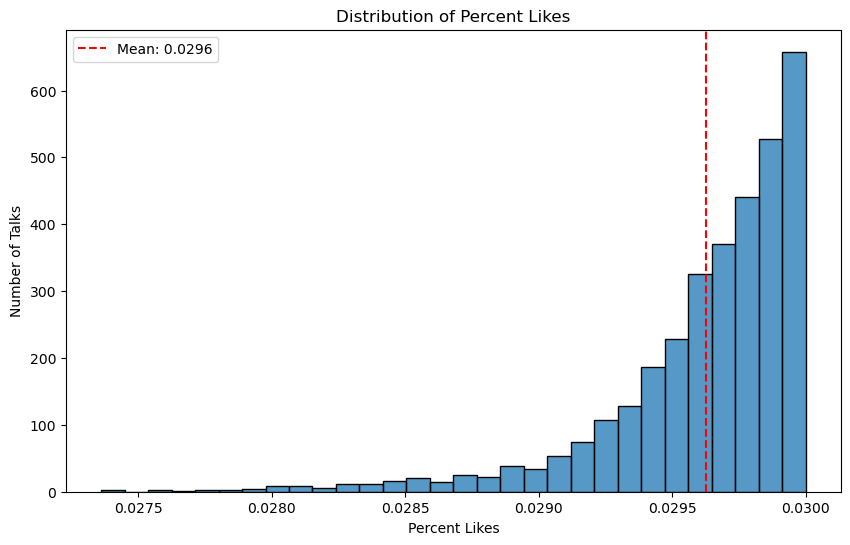

In [143]:
# Plotting the distribution
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)
# 'kde=False' turns off the Kernel Density Estimate plot overlay
# 'bins=30' specifies how many bins you want to divide your data into
# 'color' specifies the color of the histogram

# Calculating and plotting the mean
mean_value = dummy_merged_df['percent_likes'].mean()
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.4f}')
# This draws a vertical line at the mean value, '--' makes the line dashed, and ':.2f' formats the mean to 2 decimal places

plt.xlabel('Percent Likes')  # Label for the x-axis
plt.ylabel('Number of Talks')  # Label for the y-axis
plt.title('Distribution of Percent Likes')  # Title of the plot
plt.legend()  # Show the legend
plt.show()


We're first going to create a binary "good_speech" column.  We are indicating that speeches that recieved an above the mean "percent_likes" are counted as "good_speech", and those that were below the "percent_likes" mean are not.

In [ ]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

In [ ]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'view', 'multiple_speakers',
       'percent_likes', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

## Baseline Model:

Result:

Logistic Regression:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.6415165165165165 |
| Test score  | 0.6036036036036037 |

Random Forest:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.9966216216216216 |
| Test score  | 0.6066066066066066 |


Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| want know        | 0.039544    |
| people say       | 0.029546    |
| people think     | 0.026989    |
| feels like       | 0.025923    |
| dont think       | 0.025119    |
| black hole       | 0.024329    |
| know people      | 0.022076    |
| years later      | 0.021207    |
| high school      | 0.020977    |
| answer question  | 0.020397    |

Logistic Regression (bottom 10 positive coefficients):
| Feature           | Coefficient |
|-------------------|-------------|
| 20 years          | -0.016250   |
| 90 percent        | -0.017265   |
| 30 years          | -0.017755   |
| middle east       | -0.018234   |
| im going          | -0.022491   |
| just want         | -0.023509   |
| looks like        | -0.025027   |
| ladies gentlemen  | -0.026333   |
| people living     | -0.029691   |
| weve got          | -0.031859   |


Random Forest:
| Feature        | Importance |
|----------------|------------|
| years ago      | 0.012877   |
| im going       | 0.010958   |
| united states  | 0.010084   |
| dont know      | 0.009862   |
| little bit     | 0.009772   |
| looks like     | 0.009366   |
| new york       | 0.008108   |
| just like      | 0.007697   |
| years old      | 0.007577   |
| id like        | 0.007223   |

In [ ]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on CountVectorized Transcripts

We will use this as our baseline model.

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


## Random Forest Classifier Model

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


## Model Iteration

We now have solid baseline models in both a Random Forest Model, and a Logistic Regression Model

We will iterate over our selected features to see:
1. which coefficients/feature_importances we can see as having the most influence, and
2. if we can produce a better performing model

Model Iterations:

1. limit our features to only the numeric columns of the original dataset (no countvectorizing and no dummying)
2. only include countvectorization of the "transcript" column.  Adjust n_grams and Max Features and see what insights we can glean.
3. include countvectorization and topics dummies (do not include occupation dummies)

### Model Iteration: 1. limit our features to only the numeric columns of the original dataset (no countvectorizing and no dummying)

Result:

Logistic Regression:
| Metric      | Score        |
|-------------|--------------|
| Train score | 0.6415165165 |
| Test score  | 0.6036036036 |

Random Forest:
| Metric      | Score        |
|-------------|--------------|
| Train score | 1.0          |
| Test score  | 0.5750750751 |



Logistic Regression:
| Feature               | Coefficient |
|-----------------------|-------------|
| ted_mainstage         | 0.035492    |
| num_question_marks    | 0.009934    |
| laughs_per_minute     | 0.008348    |
| comments              | 0.007841    |
| questions_per_minute  | 0.007794    |
| num_laughs            | 0.007096    |
| duration              | 0.003855    |
| multiple_speakers     | -0.005425   |


Random Forest:
| Feature               | Importance |
|-----------------------|------------|
| comments              | 0.238122   |
| duration              | 0.208304   |
| questions_per_minute  | 0.190413   |
| laughs_per_minute     | 0.148356   |
| num_question_marks    | 0.114803   |
| num_laughs            | 0.069227   |
| ted_mainstage         | 0.020783   |
| multiple_speakers     | 0.009992   |


In [ ]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

In [ ]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

# since this data is already represented in the "good_speech" column, we'll drop the "percent_likes" column
ready_to_merge_numerical_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [ ]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration',
       'num_question_marks', 'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
ready_to_merge_numerical_df[columns_to_scale] = scaler.fit_transform(ready_to_merge_numerical_df[columns_to_scale])

In [ ]:
X=ready_to_merge_numerical_df.drop("good_speech", axis=1)
y=ready_to_merge_numerical_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression on Original Numerical Columns

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Assuming X_train is a pandas DataFrame
feature_names = X_train.columns

# Extracting the coefficients
coefficients = logreg.coef_[0]

# Creating a DataFrame for better readability
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sorting the DataFrame by the absolute values of the coefficients in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Printing the DataFrame
print(coefficients_df)


## Random Forest Classifier on Original Numerical Columns

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


### Model Iteration: 2. only include countvectorization of the "transcript" column.  Adjust n_grams and Max Features and see what insights we can glean.

Result:

Max Features 500, n_gram 2,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6437687688 |
| Test score   | 0.6096096096 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6512762763 |
| Test score   | 0.5990990991 |

        

Max Features 200, n_gram 2,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6441441441 |
| Test score   | 0.6096096096 |
    
    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.9962462462 |
| Test score   | 0.5855855856 |
        

Max Features 200, n_gram 3,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6415165165 |
| Test score   | 0.6036036036 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.8599849850 |
| Test score   | 0.5690690691 |


Max Features 200, n_gram 4,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6415165165 |
| Test score   | 0.6036036036 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6512762763 |
| Test score   | 0.5990990991 |




-- Coefficients and Important_Features:

Max Features 500, n_gram 2,6:

Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| want know        | 0.038674    |
| people say       | 0.028643    |
| people think     | 0.026238    |
| feels like       | 0.025608    |
| dont think       | 0.024323    |
| black hole       | 0.022536    |
| know people      | 0.022126    |
| years later      | 0.020346    |
| answer question  | 0.019935    |
| high school      | 0.019769    |

Logistic Regression (top 10 negative coefficients):
| Feature        | Coefficient |
|----------------|-------------|
| — theyre       | -0.013201   |
| looked like    | -0.013604   |
| going make     | -0.014004   |
| dont want      | -0.014266   |
| years ago      | -0.014587   |
| youre seeing   | -0.014933   |
| thats going    | -0.015702   |
| stem cells     | -0.016102   |
| 20 years       | -0.016648   |
| 90 percent     | -0.017463   |


Random Forest (top 10 feature importance):
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.008267   |
| little bit    | 0.007942   |
| im going      | 0.007934   |
| united states | 0.007818   |
| looks like    | 0.007428   |
| dont know     | 0.007099   |
| new york      | 0.006233   |
| people living | 0.005921   |
| dont want     | 0.005228   |
| id like       | 0.00519    |




Max Features 200, n_gram 2,6:

Logistic Regression (top 10 positive coefficients):

| Feature          | Coefficient |
|------------------|-------------|
| want know        | 0.039334    |
| people say       | 0.029366    |
| people think     | 0.026868    |
| feels like       | 0.026130    |
| dont think       | 0.025444    |
| black hole       | 0.023943    |
| know people      | 0.022474    |
| years later      | 0.020595    |
| high school      | 0.020350    |
| answer question  | 0.020276    |

Logistic Regression (top 10 negative coefficients):
| Feature         | Coefficient |
|-----------------|-------------|
| want talk       | -0.012010   |
| public health   | -0.012439   |
| billion people  | -0.012615   |
| whats going     | -0.012632   |
| million people  | -0.013118   |
| — theyre        | -0.013279   |
| looked like     | -0.013664   |
| dont want       | -0.013932   |
| going make      | -0.013938   |
| years ago       | -0.014915   |


Random Forest (top 10 feature importance):
| Feature        | Importance |
|----------------|------------|
| years ago      | 0.017003   |
| im going       | 0.015808   |
| united states  | 0.013924   |
| dont know      | 0.012760   |
| looks like     | 0.012600   |
| little bit     | 0.012325   |
| id like        | 0.010884   |
| new york       | 0.010279   |
| 10 years       | 0.009843   |
| just like      | 0.009789   |




Max Features 200, n_gram 3,6:

Logistic Regression (top 10 positive coefficients):
| Feature               | Coefficient |
|-----------------------|-------------|
| just little bit       | 0.012587    |
| say things like       | 0.009311    |
| martin luther king    | 0.008210    |
| blah blah blah        | 0.008072    |
| don ’ t               | 0.005960    |
| thats good thing      | 0.005930    |
| hubble space telescope| 0.005765    |
| dont know people      | 0.005476    |
| know dont know        | 0.005271    |
| music music ends      | 0.005257    |

Logistic Regression (top 10 negative coefficients):
| Feature                     | Coefficient |
|-----------------------------|-------------|
| 40 years ago                | -0.003641   |
| international space station | -0.003710   |
| doesnt look like            | -0.003868   |
| little bit different        | -0.004017   |
| 20 years ago                | -0.004078   |
| know im going               | -0.004224   |
| world trade center          | -0.004249   |
| today im going              | -0.004470   |
| world wide web              | -0.004638   |
| im going make               | -0.004904   |


Random Forest (top 10 feature importance):
| Feature             | Importance |
|---------------------|------------|
| new york city       | 0.020171   |
| new york times      | 0.014279   |
| im going tell       | 0.013936   |
| im going talk       | 0.013907   |
| 10 years ago        | 0.011581   |
| 20 years ago        | 0.010626   |
| little bit like     | 0.010120   |
| 15 years ago        | 0.009633   |
| world war ii        | 0.009455   |
| million years ago   | 0.008828   |


Max Features 200, n_gram 4,6:

Logistic Regression (top 10 positive coefficients):
| Feature                    | Coefficient |
|----------------------------|-------------|
| let tell little bit        | 0.003087    |
| martin luther king jr      | 0.002650    |
| im going im going          | 0.001601    |
| make world better place    | 0.001591    |
| — dont know —              | 0.001372    |
| im going tell story        | 0.001089    |
| cut long story short       | 0.000941    |
| going talk little bit      | 0.000657    |
| im going talk little       | 0.000299    |
| dont know dont know        | 0.000094    |

Logistic Regression (top 10 negative coefficients) :
| Feature                      | Coefficient |
|------------------------------|-------------|
| dont know dont know          | 0.000094    |
| know whats going happen      | -0.000414   |
| want talk little bit         | -0.001542   |
| today im going talk          | -0.002334   |
| id like talk today           | -0.003330   |
| thank chris anderson thank   | -0.003408   |
| im going talk today          | -0.003448   |
| weve come long way           | -0.004327   |
| small thing big idea         | -0.004327   |
| thank thank thank thank      | -0.006758   |


Random Forest (top 10 feature importance):
| Feature                    | Importance |
|----------------------------|------------|
| weve come long way         | 0.108924   |
| thank thank thank thank    | 0.105864   |
| small thing big idea       | 0.092390   |
| thank chris anderson thank | 0.084021   |
| im going talk today        | 0.076134   |
| id like talk today         | 0.063073   |
| let tell little bit        | 0.056309   |
| make world better place    | 0.049534   |
| dont know dont know        | 0.047605   |
| today im going talk        | 0.046653   |

In [ ]:
# Creating a Transcript Only Dataframe
only_transcript_df = merged_cleaved_df[['percent_likes', 'transcript']]
only_transcript_df

In [ ]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = only_transcript_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
only_transcript_df['good_speech'] = (only_transcript_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

only_transcript_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [ ]:
only_transcript_df

### Max Features 500, n_gram 2,6:

In [ ]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=500) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression Max Features 500, n_gram 2,6:

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


## Random Forest Classifier Model on Max Features 500, n_gram 2,6:

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


## Max Features = 200, n_gram = 2,6

In [ ]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on Max Features 200, n_gram 2,6:

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


## Random Forest Classifier Model on Max Features 200, n_gram 2,6:

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


## Max Features = 200, n_gram = 3,6

In [ ]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(3, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on Max Features 200, n_gram 3,6:

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


## Random Forest Classifier Model on Max Features 200, n_gram 3,6:

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


## Max Features = 200, n_gram = 4,6

In [ ]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(4, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on Max Features = 200, n_gram = 4,6

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


## Random Forest Classifier Model on Max Features = 200, n_gram = 4,6

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


### Model Iteration: 3. include countvectorization and topics dummies (do not include occupation dummies)

Result:
Logistic Regression:
- Train score: 0.6437687687687688
- Test score: 0.6096096096096096

Random Forest:
- Train score: 0.996996996996997    
- Test score: 0.5900900900900901
    

Logistic Regression (top 10 positive coefficients):
| Feature       | Coefficient |
|---------------|-------------|
| want know     | 0.039126    |
| people say    | 0.029091    |
| people think  | 0.026444    |
| feels like    | 0.026033    |
| dont think    | 0.025069    |
| black hole    | 0.024175    |
| know people   | 0.022336    |
| years later   | 0.020470    |
| high school   | 0.020177    |
| answer question| 0.020100    |

Logistic Regression (top 10 negative coefficients):

| Feature          | Coefficient |
|------------------|-------------|
| 90 percent       | -0.017563   |
| 30 years         | -0.018234   |
| middle east      | -0.018441   |
| ♫ ♫              | -0.019905   |
| im going         | -0.023090   |
| just want        | -0.023170   |
| ladies gentlemen | -0.025534   |
| looks like       | -0.025968   |
| people living    | -0.029898   |
| weve got         | -0.031898   |


Random Forest:
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.012858   |
| united states | 0.010669   |
| im going      | 0.010316   |
| little bit    | 0.010272   |
| dont know     | 0.010134   |
| looks like    | 0.009707   |
| id like       | 0.008441   |
| years old     | 0.007860   |
| things like   | 0.007416   |
| new york      | 0.007234   |

## Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [ ]:
pd.options.display.max_rows = 40

In [ ]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df["transcript"] = merged_cleaved_df["transcript"] # Adding the transcript column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [ ]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(ready_to_merge_numerical_df.shape)

In [ ]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [ ]:
dummy_merged_df = pd.concat([topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

In [ ]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [ ]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [ ]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

In [ ]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on Transcripts, Numerical Columns, and Topics

We will use this as our baseline model.

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


## Random Forest Classifier Model

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


### Model Iteration: 4. only analyzing original numerical features and topics dummies (do not include occupation dummies, and do not countvectorize)

Result:
Logistic Regression:
- Train score: 0.6415165165165165
- Test score: 0.6036036036036037

Random Forest:
- Train score: 0.996996996996997
- Test score: 0.5900900900900901


Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| society          | 0.036462    |
| ted_mainstage    | 0.036185    |
| personal growth  | 0.024413    |
| social change    | 0.021618    |
| work             | 0.021587    |
| business         | 0.018524    |
| leadership       | 0.017687    |
| psychology       | 0.017051    |
| humanity         | 0.016938    |
| education        | 0.016009    |

Logistic Regression (top 10 negative coefficients):
| Feature        | Coefficient |
|----------------|-------------|
| india          | -0.011716   |
| entertainment  | -0.011894   |
| live music     | -0.012179   |
| war            | -0.014048   |
| TEDx           | -0.015971   |
| technology     | -0.016110   |
| art            | -0.018632   |
| science        | -0.019537   |
| design         | -0.027669   |
| global issues  | -0.045344   |



Random Forest (top 10 feature importance):
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.012858   |
| united states | 0.010669   |
| im going      | 0.010316   |
| little bit    | 0.010272   |
| dont know     | 0.010134   |
| looks like    | 0.009707   |
| id like       | 0.008441   |
| years old     | 0.007860   |
| things like   | 0.007416   |
| new york      | 0.007234   |

Random Forest (bottom 10 feature importance):
| Feature      | Importance |
|--------------|------------|
| ill just     | 0.001656   |
| didnt really | 0.001655   |
| going work   | 0.001508   |
| ’ t          | 0.001504   |
| lot things   | 0.001476   |
| think youre  | 0.001470   |
| know theyre  | 0.001445   |
| think going  | 0.001405   |
| people make  | 0.001290   |
| black hole   | 0.000873   |

## Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [ ]:
pd.options.display.max_rows = 40

In [ ]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [ ]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(ready_to_merge_numerical_df.shape)

In [ ]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [ ]:
dummy_merged_df = pd.concat([topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

In [ ]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [ ]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [ ]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression on Numerical Columns, and Topics

We will use this as our baseline model.

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

What are the features with the highest coefficients (which features were most impactful in the model?)

In [ ]:
feature_names = X_train.columns

# Extracting coefficients
coefficients = logreg.coef_[0]

# Check if the length of feature names matches the length of coefficients
if len(feature_names) == len(coefficients):
    # Create a pandas DataFrame for easier manipulation
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort the DataFrame to show features with the highest coefficient values at the top
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    # Display the top N most impactful features
    print(coefficients_df.head(10))  # Adjust the number of features you want to display
    print(coefficients_df.tail(10))
else:
    print("Mismatch in the length of feature names and coefficients")

## Random Forest Classifier on Numerical Columns, and Topics

In [ ]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

In [ ]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
# This assumes that 'bagofwords_transcript' was used to transform the data fed into the Random Forest
feature_names = bagofwords_transcript.get_feature_names_out()

# Check if the length of feature names matches the length of feature importances
if len(feature_names) == len(feature_importances):
    # Create a pandas DataFrame for easier manipulation and visualization
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame to show the most important features at the top
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    print(features_df.head(10))
    print(features_df.tail(10))  
else:
    print("Mismatch in the length of feature names and importances")

## Only Topics

Results:

Logistic Regression:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.6415165165165165 |
| Test score  | 0.6036036036036037 |


Random Forest:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.9973723723723724 |
| Test score  | 0.6171171171171171 |



Logistic Regression (Top 10 Coefficients)
| Feature          | Coefficient |
|------------------|-------------|
| society          | 0.036170    |
| personal growth  | 0.024280    |
| work             | 0.021501    |
| social change    | 0.021344    |
| business         | 0.018442    |
| leadership       | 0.017648    |
| psychology       | 0.017092    |
| humanity         | 0.016840    |
| education        | 0.015957    |
| communication    | 0.015277    |

Logistic Regression (Bottom 10 Coefficients)
| Feature       | Coefficient |
|---------------|-------------|
| Africa        | -0.011622   |
| india         | -0.011786   |
| live music    | -0.012104   |
| war           | -0.014104   |
| technology    | -0.015705   |
| TEDx          | -0.017136   |
| art           | -0.018498   |
| science       | -0.019425   |
| design        | -0.027372   |
| global issues | -0.045442   |


Random Forest (Top 10 Features):
| Feature       | Importance |
|---------------|------------|
| technology    | 0.015786   |
| TEDx          | 0.015405   |
| culture       | 0.015356   |
| global issues | 0.012585   |
| science       | 0.011720   |
| design        | 0.011125   |
| business      | 0.010850   |
| entertainment | 0.009887   |
| society       | 0.009571   |
| art           | 0.009509   |



Random Forest (Bottom 10 Features):
| Feature         | Importance |
|-----------------|------------|
| skateboarding   | 0.000060   |
| cooperation     | 0.000047   |
| autism          | 0.000026   |
| cloud           | 0.000018   |
| start-up        | 0.000016   |
| evil            | 0.000006   |
| Social Science  | 0.000005   |
| rap             | 0.000002   |
| exoskeleton     | 0.000000   |
| neurology       | 0.000000   |



In [ ]:
pd.options.display.max_rows = 40

In [119]:
# Dropping the non numerical columns
only_topics_df = ready_to_merge_numerical_df[["percent_likes"]]
print(only_topics_df.shape)

(3330, 1)


We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [120]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(only_topics_df.shape)

(3330, 449)
(3330, 1)


In [121]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
only_topics_df_reset = only_topics_df.reset_index(drop=True)

In [122]:
dummy_merged_df = pd.concat([topics_df_reset, only_topics_df_reset], axis=1)
dummy_merged_df.shape

(3330, 450)

In [123]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [ ]:
# # Scaling the data

# # Initialize the Min-Max Scaler
# scaler = MinMaxScaler()

# # List of columns to scale
# columns_to_scale = ['comments', 'duration', 'num_question_marks',
#        'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# # Scale the selected columns and replace in the dataframe
# dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [124]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression on Topics

We will use this as our baseline model.

In [125]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.001, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [126]:
feature_names = X_train.columns

# Extracting coefficients
coefficients = logreg.coef_[0]

# Check if the length of feature names matches the length of coefficients
if len(feature_names) == len(coefficients):
    # Create a pandas DataFrame for easier manipulation
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort the DataFrame to show features with the highest coefficient values at the top
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    # Display the top N most impactful features
    print(coefficients_df.head(10))  # Adjust the number of features you want to display
    print(coefficients_df.tail(10))
else:
    print("Mismatch in the length of feature names and coefficients")

             Feature  Coefficient
388          society     0.036170
328  personal growth     0.024280
443             work     0.021501
386    social change     0.021344
108         business     0.018442
259       leadership     0.017648
358       psychology     0.017092
233         humanity     0.016840
169        education     0.015957
125    communication     0.015277
           Feature  Coefficient
3           Africa    -0.011622
240          india    -0.011786
263     live music    -0.012104
435            war    -0.014104
411     technology    -0.015705
57            TEDx    -0.017136
78             art    -0.018498
372        science    -0.019425
156         design    -0.027372
214  global issues    -0.045442


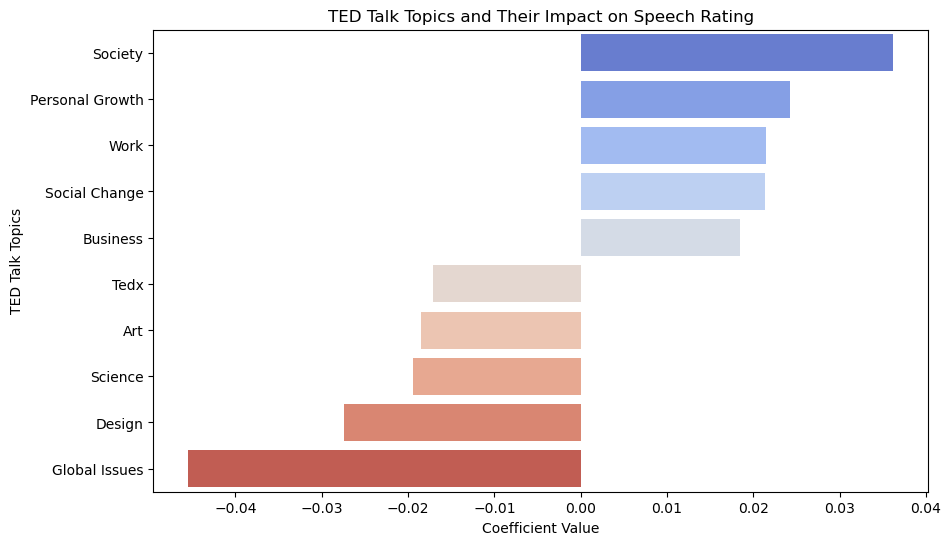

In [137]:
name_mapping = {
    'society': 'Society',
    'personal growth': 'Personal Growth',
    'work': 'Work',
    'social change': 'Social Change',
    'business': 'Business',
    'TEDx': 'Tedx',
    'art': 'Art',
    'science': 'Science',
    'design': 'Design',
    'global issues': 'Global Issues'
}

# Apply the name mapping to the 'Feature' column
coefficients_df['Feature'] = coefficients_df['Feature'].map(name_mapping).fillna(coefficients_df['Feature'])

# Extracting top 5 and bottom 5 coefficients
top_5 = coefficients_df.head(5)
bottom_5 = coefficients_df.tail(5)

# Combining top 5 and bottom 5 for plotting
combined_df = pd.concat([top_5, bottom_5])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=combined_df, palette="coolwarm")
plt.title('TED Talk Topics and Their Impact on Speech Rating')
plt.xlabel('Coefficient Value')
plt.ylabel('TED Talk Topics')

# Show plot
plt.show()

## Random Forest Classifier on Topics

In [127]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.9973723723723724
Test score: 0.6171171171171171


In [132]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
# This assumes that 'bagofwords_transcript' was used to transform the data fed into the Random Forest
feature_names = X_train.columns

# Check if the length of feature names matches the length of feature importances
if len(feature_names) == len(feature_importances):
    # Create a pandas DataFrame for easier manipulation and visualization
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame to show the most important features at the top
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    print(features_df.head(10))
    print(features_df.tail(10))  
else:
    print("Mismatch in the length of feature names and importances")

           Feature  Importance
411     technology    0.015786
57            TEDx    0.015405
145        culture    0.015356
214  global issues    0.012585
372        science    0.011720
156         design    0.011125
108       business    0.010850
176  entertainment    0.009887
388        society    0.009571
78             art    0.009509
            Feature  Importance
383   skateboarding    0.000060
135     cooperation    0.000047
85           autism    0.000026
120           cloud    0.000018
398        start-up    0.000016
180            evil    0.000006
41   Social Science    0.000005
363             rap    0.000002
184     exoskeleton    0.000000
306       neurology    0.000000


### Various Visualizations

#### Questions/Laughs/Words per minute

In [ ]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a scatter plot for 'questions_per_minute'
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['questions_per_minute'], color='blue', alpha=0.5, label='Questions per Minute')

# Create a scatter plot for 'laughs_per_minute' on the same axes
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['laughs_per_minute'], color='red', alpha=0.5, label='Laughs per Minute')

# Create a scatter plot for 'words_per_minute' on the same axes
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['words_per_minute'], color='green', alpha=0.5, label='Words per Minute')

# Adding title and labels
plt.title('Questions, Laughs, and Words per Minute vs Percent Likes')
plt.xlabel('Percent Likes')
plt.ylabel('Frequency per Minute')

# Adding legend to distinguish the groups
plt.legend()

# Show the plot
plt.show()

We will have to scale this data to get a better visualization.

In [ ]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes']

# Scale the selected columns and replace in the dataframe
merged_cleaved_df[columns_to_scale] = scaler.fit_transform(merged_cleaved_df[columns_to_scale])

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create scatter plots for the scaled variables
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['words_per_minute'], color='green', alpha=0.3, label='Words per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['questions_per_minute'], color='blue', alpha=0.3, label='Questions per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['laughs_per_minute'], color='red', alpha=0.3, label='Laughs per Minute')


# Adding title and labels
plt.title('Questions, Laughs, and Words per Minute vs Percent Likes (Scaled)')
plt.xlabel('Percent Likes (Scaled)')
plt.ylabel('Frequency per Minute (Scaled)')

# Adding legend to distinguish the groups
plt.legend()

# Show the plot
plt.show()




## Percent_Likes Correlation: Correlating with Topics

In [ ]:
# Adding 'percent_likes' to the topics DataFrame for correlation analysis
topics_with_likes = pd.concat([topics_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = topics_with_likes.corr()['percent_likes']

# Dropping 'percent_likes' correlation with itself
correlation = correlation.drop(labels=['percent_likes'])

# Sorting the correlations to find the top 100 topics
top_20_topics = correlation.sort_values(ascending=False).head(20)
bottom_20_topics = correlation.sort_values(ascending=True).head(20)

# Displaying the top 100 topics
print(top_20_topics)
print(bottom_20_topics)

## Percent_Likes Correlation: Correlating with Occupations

In [ ]:
# Adding 'percent_likes' to the occupations DataFrame for correlation analysis
occupations_with_likes = pd.concat([occupations_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = occupations_with_likes.corr()['percent_likes']

# Dropping 'percent_likes' correlation with itself
correlation = correlation.drop(labels=['percent_likes'])

# Sorting the correlations to find the top 100 topics
top_20_topics = correlation.sort_values(ascending=False).head(20)
bottom_20_topics = correlation.sort_values(ascending=True).head(20)

# Displaying the top 100 topics
print(top_20_topics)
print(bottom_20_topics)

In [ ]:
import matplotlib.pyplot as plt

# Top 10 topics with highest positive correlation
top_10_positive_topics = top_20_topics.head(10)

# Top 10 topics with highest negative correlation
# Remember, in bottom_100_topics, the most negative correlations are at the end, so we use tail()
top_10_negative_topics = bottom_20_topics.tail(10)

# Plotting the top 10 topics with highest positive correlation
plt.figure(figsize=(10, 3))
top_10_positive_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Positive Correlation with Percent Likes')
plt.xlabel('Topics')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

# Plotting the top 10 topics with highest negative correlation
plt.figure(figsize=(10, 3))
top_10_negative_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Negative Correlation with Percent Like NOTE I DID THIS WRONG!!!')
plt.xlabel('Topics')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


## Percent_Likes Correlation: Correlating with Various Features

In [ ]:
correlation = merged_cleaved_df[['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes', 'ted_mainstage', 'published_year', 'published_month', 'recorded_year', 'recorded_month']].corr()
print(correlation['percent_likes'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your actual DataFrame here
# merged_cleaved_df = pd.read_csv('your_file.csv')

# Calculate the correlation matrix
correlation = merged_cleaved_df[['published_year', 'published_month', 'recorded_year', 'recorded_month', 'percent_likes']].corr()

# Extracting the correlation of specified columns with 'percent_likes'
correlation_with_percent_likes = correlation['percent_likes'].drop('percent_likes', errors='ignore')

# Plotting a bar chart
plt.figure(figsize=(8, 6))
correlation_with_percent_likes.plot(kind='bar')
plt.title('Correlation with Percent Likes')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Dates')
plt.show()


In [ ]:
# Creating dummy variables for 'published_year' and 'recorded_year'
published_year_dummies = pd.get_dummies(merged_cleaved_df['published_year'], prefix='pub_year')
recorded_year_dummies = pd.get_dummies(merged_cleaved_df['recorded_year'], prefix='rec_year')

# Combining the dummy variables with 'percent_likes'
combined_df = pd.concat([merged_cleaved_df['percent_likes'], published_year_dummies, recorded_year_dummies], axis=1)

# Calculating the correlation
correlation = combined_df.corr()

# Extracting correlation with 'percent_likes' and removing the self-correlation
correlation_with_percent_likes = correlation['percent_likes'].drop('percent_likes', errors='ignore')

# Sorting the correlations to find the top ones
sorted_correlation = correlation_with_percent_likes.sort_values(ascending=False)

# Plotting the top correlations for 'published_year' and 'recorded_year'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Top correlations for 'published_year'
top_published_year = sorted_correlation.filter(like='pub_year').head(10)
top_published_year.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 10 Correlations with Percent Likes - Published Year')
axes[0].set_ylabel('Correlation Coefficient')

# Top correlations for 'recorded_year'
top_recorded_year = sorted_correlation.filter(like='rec_year').head(10)
top_recorded_year.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Top 10 Correlations with Percent Likes - Recorded Year')
axes[1].set_ylabel('Correlation Coefficient')

plt.tight_layout()
plt.show()


# Linear Regression on Various Features

In [100]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
#ready_to_merge_numerical_df.drop(["good_speech"], axis=1, inplace=True) # Dropping the good_speech column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   multiple_speakers     3330 non-null   int64  
 3   percent_likes         3330 non-null   float64
 4   ted_mainstage         3330 non-null   int64  
 5   word_count            3330 non-null   int64  
 6   words_per_minute      3330 non-null   float64
 7   num_question_marks    3330 non-null   int64  
 8   questions_per_minute  3330 non-null   float64
 9   num_laughs            3330 non-null   int64  
 10  laughs_per_minute     3330 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 312.2 KB
(3330, 11)


In [101]:
ready_to_merge_numerical_df.columns

Index(['comments', 'duration', 'multiple_speakers', 'percent_likes',
       'ted_mainstage', 'word_count', 'words_per_minute', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute'],
      dtype='object')

In [102]:
# Dropping the 'transcript' column

# Selecting the independent and dependent variables
X = ready_to_merge_numerical_df.drop('percent_likes', axis=1)
y = ready_to_merge_numerical_df['percent_likes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

# Displaying the coefficients
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
print(coefficients)


R^2 Score: 0.010225277514163689
                       Coefficient
laughs_per_minute     6.814619e-03
ted_mainstage         1.581614e-05
num_question_marks    3.066136e-06
comments              1.793214e-07
word_count            1.076774e-08
duration             -3.118684e-08
num_laughs           -5.117746e-06
words_per_minute     -2.340765e-05
multiple_speakers    -1.061302e-04
questions_per_minute -9.702146e-04


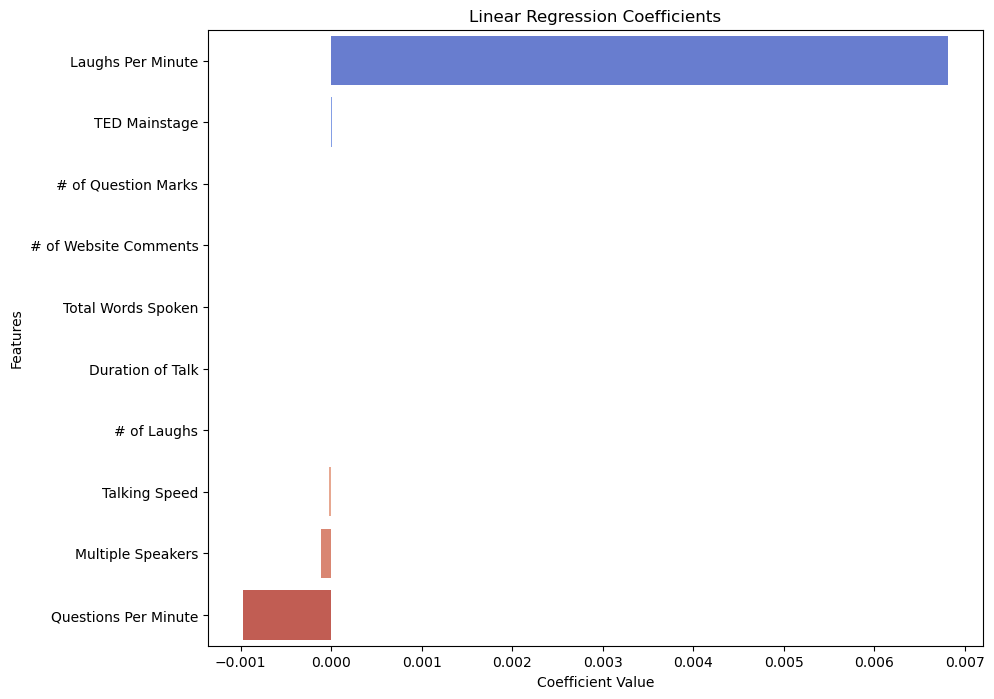

In [144]:

name_mapping = {
    'laughs_per_minute': 'Laughs Per Minute',
    'ted_mainstage': 'TED Mainstage',
    'num_question_marks': '# of Question Marks',
    'comments': '# of Website Comments',
    'word_count': 'Total Words Spoken',
    'duration': 'Duration of Talk',
    'num_laughs': '# of Laughs',
    'words_per_minute': 'Talking Speed',
    'multiple_speakers': 'Multiple Speakers',
    'questions_per_minute': 'Questions Per Minute'
}

# Assuming 'coefficients_reset' is your DataFrame from before
# Rename the columns based on your mapping
coefficients_reset['Feature'] = coefficients_reset['Feature'].map(name_mapping).fillna(coefficients_reset['Feature'])

# Now create the bar plot with updated feature names
plt.figure(figsize=(10, 8))  # Set figure size for better visibility
sns.barplot(x='Coefficient', y='Feature', data=coefficients_reset, palette='coolwarm')
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

# Show plot
plt.show()


# LogReg Coefficients

In [103]:
# Determining the top 20 coefficient words for positive reviews
# This code was adapted from BrainStation's Text Data lecture notebook
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords_transcript.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The top 10 positive model coefficients indicating higher ratings")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

NameError: name 'logreg' is not defined

In [ ]:
# Determining the top 20 coefficient words for positive reviews
# This code was adapted from BrainStation's Text Data lecture notebook
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords_transcript.get_feature_names_out()
).sort_values("coefficients", ascending=True)

word_counts.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The top 10 negative model coefficients indicating higher ratings")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [ ]:
sparse_matrix_train_df = pd.DataFrame(data=sparse_matrix_train.toarray(), columns=bagofwords_transcript.get_feature_names_out(), index=X_train.index)
sparse_matrix_test_df = pd.DataFrame(data=sparse_matrix_test.toarray(), columns=bagofwords_transcript.get_feature_names_out(), index=X_test.index)

In [ ]:
merged_cleaved_df

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?
- recorded_date     3331 non-null   object **Changed to DateTime**
- published_date    3331 non-null   object **Changed to DateTime**
####  - event             3331 non-null   object **Ready for Dummies**

#### Additional Columns Created:
- published_year **ready for dummy variables**
- published_month **ready for dummy variables**
- recorded_year **ready for dummy variables**
- recorded_month **ready for dummy variables**
- percent_likes
- ted_mainstage 
- multiple_speakers 
- word_count
- words_minute
- transformed_occupations **ready for dummy variables**

In [ ]:
merged_cleaved_df

## Next Steps:

Create dummy variables where possible.
- event  **Ready for Dummies**
- published_year **ready for dummy variables**
- published_month **ready for dummy variables**
- recorded_year **ready for dummy variables**
- recorded_month **ready for dummy variables**
- transformed_occupations **ready for dummy variables**


Scale my dependent variable of "percent-likes"
scale other non-dummy-variable columns
- comments
- views
- duration
- word_count
- words_minute

Drop the "likes" column, as it will correlate too strongly with 'percent_likes'.



For Future Consideration:
- available_lang    3331 non-null   object **Create dummies?** *temporarily drop*
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?


## Creating Dummy Variables:


In [ ]:
merged_cleaved_df

In [ ]:
# List of columns for which to create dummy variables
columns_to_dummify = [
    'event',
    'published_year',
    'published_month',
    'recorded_year',
    'recorded_month',
    'transformed_occupations'
]

# Creating dummy variables
for column in columns_to_dummify:
    dummies = pd.get_dummies(merged_cleaved_df[column], prefix=column)
    merged_cleaved_df = pd.concat([merged_cleaved_df, dummies], axis=1)
    merged_cleaved_df.drop(column, axis=1, inplace=True)

In [ ]:
merged_cleaved_df

In [ ]:
# Dropping the "likes" column
merged_cleaved_df.drop(["likes"], axis=1, inplace=True)

# Creating a Temporary EDA DataFrame for only the numerical values that we have thus far:

This means dropping the following columns:
    'talk_id',
    'occupations',
    'about_speakers',
    'available_lang',
    'topics',
    'related_talks',
    'description',
    'transcript',
    'title',
    'speaker'

In [ ]:
# List of columns to drop
columns_to_drop = [
    'talk_id',
    'occupations',
    'about_speakers',
    'available_lang',
    'topics',
    'related_talks',
    'description',
    'transcript',
    'title',
    'speaker',
    'published_date',
    'recorded_date'
]

# Creating a new DataFrame by dropping specified columns
numeric_temp_df = merged_cleaved_df.drop(columns=columns_to_drop)
numeric_temp_df.info()

We now have a temporary dataframe called "numeric_temp_df" with which we can run a linear regression against our dependent variable "percent_likes"

In [ ]:
# Assuming your DataFrame is named numeric_temp_df and 'percent_likes' is your target variable
X = numeric_temp_df.drop('percent_likes', axis=1)  # Features (all columns except 'percent_likes')
y = numeric_temp_df['percent_likes']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data (do not fit the scaler again!)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
model = LinearRegression(n_jobs=-1)

# Fit the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Now you can use model.predict(X_test_scaled) to make predictions on your test set

In [ ]:
# 1. Calculate Accuracy Scores
# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate R² score for training and testing sets
r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print("R² score for training set:", r2_score_train)
print("R² score for testing set:", r2_score_test)

# 2. Identify Top 50 Positive and Negative Coefficients
# Get the coefficients from the model and create a Series with column names
coefficients = pd.Series(model.coef_, index=X.columns)

# Sort the coefficients
sorted_coefficients = coefficients.sort_values()

# Top 50 negative coefficients
top_50_negative = sorted_coefficients.head(50)

# Top 50 positive coefficients
top_50_positive = sorted_coefficients.tail(50).sort_values(ascending=False)

print("Top 50 positive coefficients:\n", top_50_positive)
print("\nTop 50 negative coefficients:\n", top_50_negative)

## Next Steps:

Let's look at the distribution of the column "percent_likes" to see if we can determine which talks are "great" talks and which ones are not.

We will then create a binary variable at this level, and then run a logistic regression against this target variable.

In [ ]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = StandardScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Std Scaler) Percent Likes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Min/Max) Percent Likes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = RobustScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Robust) Percent Likes')
plt.ylabel('Frequency')
plt.show()